# Test on 3D models

#### Classification and Matching on standard 3D objects

--------------------------------------------------------------------------------------------------------------------------------

    Import packages

In [1]:
import numpy as np
import collections
#from tensorflow.python.framework import dtypes

from os import listdir
import os
from os.path import isfile, join
import numpy as np
import cv2
import scipy as misc

import matplotlib.pylab as plt
%matplotlib inline

from __future__ import division
from __future__ import print_function

import argparse
import sys

import glob
#import param
import time

#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
import IPython.display as display

import tensorflow as tf

#import pydotplus as pydot
#import graphviz



# KERAS IMPORTS
import keras
from keras import applications
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import History 
from keras.models import model_from_json

#SKLEARN
from sklearn.metrics import classification_report

C:\Users\TempUser\Anaconda3\envs\CPU_tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define Generate Model Function

In [2]:
def generate_model(name):
    #path to directory
    path_train = 'data/'+name+'/_train/'
    path_test = 'data/'+name+'/_val/'
    path_val = 'data/'+name+'/_val/'

    img_size= 200

    #get folder names
    def directory_scan(path):
        dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
        return dirlist

    #build labels and image arrays, resize image to 500*500
    def read_images_in_folder(dirlist, path):
        images=[]
        labels = []
        count = 0
        for i in range(len(dirlist)):
            image_stack = []
            for img in glob.glob(path+dirlist[i]+'/*jpg'):
                count=count+1
                labels.append(dirlist[i])
                IMG = cv2.imread(img)
                #RGB to grey scale
                #IMG_2= cv2.cvtColor( IMG, cv2.COLOR_RGB2GRAY )
                #resize to 100*100
                im_resize = cv2.resize(IMG, (img_size, img_size), 3)
                images.append(im_resize)
            #np_images = np.array(image_stack)

        return images, labels, count

    dirlist_val = directory_scan(path_val)
    dirlist_train = directory_scan(path_train)

    if __name__ == '__main__':
        dirlist_train = directory_scan(path_train)
        images_train,labels_train,count_train = read_images_in_folder(dirlist_train, path_train)

    if __name__ == '__main__':
        dirlist_val = directory_scan(path_val)
        images_val,labels_val,count_val= read_images_in_folder(dirlist_val, path_val)

    print('There are '+ str(count_train) +' training images')
    print('There are '+ str(count_val) +' validation images')

    nb_img_train = count_train
    nb_img_val = count_val

    train_labels = labels_train
    train_images = images_train
    val_images = images_val
    val_labels = labels_val

    #prepare and reshape testing/training sets
    val_img = np.array(val_images).astype('float32')/255
    train_img = np.array(train_images).astype('float32')/255

    #One hot encoding
    k=0
    for i in range(len(dirlist_train)):
        for j in range(len(train_labels)):
            if(train_labels[j]==dirlist_train[i]):
                train_labels[j]=k
        k=k+1

    #Validation
    g=0
    for l in range(len(dirlist_val)):
        for h in range(len(val_labels)):
            if(val_labels[h]==dirlist_val[l]):
                val_labels[h]=g
        g=g+1

    train_lab= to_categorical(train_labels)
    val_lab = to_categorical(val_labels)

    #make model
    conv_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

    #gets feature maps for dataset based on inital VGG model
    #    >>from training set to feature map
    start = time.time()
    train_features = conv_base.predict(train_img, verbose=1)
    #train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))
    stop = time.time()
    print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")
    #reshape feature maps to match output of VGG model with input of additional layers
    train_features_ = np.reshape(train_features, (len(train_img), 6 * 6 * 512))

    #gets feature maps for dataset based on inital VGG model
    #    >>from training set to feature map
    start = time.time()
    val_features = conv_base.predict(val_img, verbose=1)
    #train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))
    stop = time.time()
    print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")
    val_features = np.reshape(val_features, (len(val_img), 6 * 6 * 512))

    #Build model
    model = models.Sequential()
    model.add(layers.Dense(600, activation='relu', input_dim=6 * 6 * 512))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(600, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(len(dirlist_train), activation='softmax'))
    history= History()

    model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    training = model.fit(train_features_,
                        train_lab,
                        epochs=90,
                        batch_size=100,
                        validation_data=(val_features,val_lab), callbacks=[history])

    # serialize model to JSON
    model_json = model.to_json()
    with open("model/model_"+name+".json", "w") as json_file:
        json_file.write(model_json)
        # serialize weights to HDF5
    model.save_weights("model/model_"+name+".h5")
    print("Saved model to disk")

--------------------------------------------------------------------------------------------------------------------------------

# Generate Model

sofa stairs table toilet

In [3]:
generate_model('sofa')

There are 6000 training images
There are 2000 validation images
6000/6000 [==============================] - 2104s 351ms/step
Execution time = 35 min 3.7572178840637207 sec
2000/2000 [==============================] - 1021s 510ms/step
Execution time = 17 min 0.6915802955627441 sec
Train on 6000 samples, validate on 2000 samples
Epoch 1/90
6000/6000 [==============================] - 15s 3ms/step - loss: 5.3919 - acc: 0.0045 - val_loss: 5.2990 - val_acc: 0.0035
Epoch 2/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.3104 - acc: 0.0047 - val_loss: 5.2976 - val_acc: 0.0065
Epoch 3/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.3019 - acc: 0.0032 - val_loss: 5.2975 - val_acc: 0.0045
Epoch 4/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.2998 - acc: 0.0043 - val_loss: 5.2973 - val_acc: 0.0070
Epoch 5/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.2990 - acc: 0.0033 - val_loss: 5.2953 - val_acc: 0.

Epoch 59/90
6000/6000 [==============================] - 15s 2ms/step - loss: 4.0003 - acc: 0.0788 - val_loss: 3.8297 - val_acc: 0.1750
Epoch 60/90
6000/6000 [==============================] - 15s 2ms/step - loss: 4.0003 - acc: 0.0778 - val_loss: 3.8719 - val_acc: 0.1585
Epoch 61/90
6000/6000 [==============================] - 15s 2ms/step - loss: 3.9584 - acc: 0.0838 - val_loss: 3.8374 - val_acc: 0.1710
Epoch 62/90
6000/6000 [==============================] - 15s 3ms/step - loss: 3.9633 - acc: 0.0780 - val_loss: 3.8975 - val_acc: 0.1465
Epoch 63/90
6000/6000 [==============================] - 15s 3ms/step - loss: 3.9389 - acc: 0.0858 - val_loss: 3.8531 - val_acc: 0.1515
Epoch 64/90
6000/6000 [==============================] - 15s 3ms/step - loss: 3.8850 - acc: 0.0840 - val_loss: 3.8255 - val_acc: 0.1770
Epoch 65/90
6000/6000 [==============================] - 15s 3ms/step - loss: 3.9202 - acc: 0.0877 - val_loss: 3.8834 - val_acc: 0.1435
Epoch 66/90
6000/6000 [=========================

In [4]:
generate_model('stairs')

There are 3600 training images
There are 1200 validation images
3600/3600 [==============================] - 1299s 361ms/step
Execution time = 21 min 39.2822482585907 sec
1200/1200 [==============================] - 416s 347ms/step
Execution time = 6 min 56.032618284225464 sec
Train on 3600 samples, validate on 1200 samples
Epoch 1/90
3600/3600 [==============================] - 9s 2ms/step - loss: 4.9301 - acc: 0.0072 - val_loss: 4.7773 - val_acc: 0.0142
Epoch 2/90
3600/3600 [==============================] - 8s 2ms/step - loss: 4.8077 - acc: 0.0114 - val_loss: 4.7751 - val_acc: 0.0158
Epoch 3/90
3600/3600 [==============================] - 8s 2ms/step - loss: 4.7884 - acc: 0.0133 - val_loss: 4.7550 - val_acc: 0.0183
Epoch 4/90
3600/3600 [==============================] - 8s 2ms/step - loss: 4.7761 - acc: 0.0114 - val_loss: 4.7289 - val_acc: 0.0250
Epoch 5/90
3600/3600 [==============================] - 8s 2ms/step - loss: 4.7388 - acc: 0.0167 - val_loss: 4.6657 - val_acc: 0.0275
Epoc

In [5]:
generate_model('table')

There are 6000 training images
There are 2000 validation images
6000/6000 [==============================] - 2022s 337ms/step
Execution time = 33 min 42.068084716796875 sec
2000/2000 [==============================] - 719s 359ms/step
Execution time = 11 min 58.87674689292908 sec
Train on 6000 samples, validate on 2000 samples
Epoch 1/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.3839 - acc: 0.0043 - val_loss: 5.2850 - val_acc: 0.0110
Epoch 2/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.2933 - acc: 0.0062 - val_loss: 5.2501 - val_acc: 0.0070
Epoch 3/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.2268 - acc: 0.0082 - val_loss: 5.1498 - val_acc: 0.0095
Epoch 4/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.1425 - acc: 0.0087 - val_loss: 5.0688 - val_acc: 0.0105
Epoch 5/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.0695 - acc: 0.0100 - val_loss: 5.0055 - val_acc: 0.02

Epoch 59/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.8653 - acc: 0.2648 - val_loss: 2.5496 - val_acc: 0.4345
Epoch 60/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.8735 - acc: 0.2637 - val_loss: 2.5238 - val_acc: 0.4530
Epoch 61/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.8575 - acc: 0.2637 - val_loss: 2.4830 - val_acc: 0.4440
Epoch 62/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.8826 - acc: 0.2645 - val_loss: 2.4434 - val_acc: 0.4655
Epoch 63/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.8295 - acc: 0.2722 - val_loss: 2.4546 - val_acc: 0.4625
Epoch 64/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.7859 - acc: 0.2778 - val_loss: 2.4404 - val_acc: 0.4625
Epoch 65/90
6000/6000 [==============================] - 14s 2ms/step - loss: 2.7743 - acc: 0.2795 - val_loss: 2.4119 - val_acc: 0.4650
Epoch 66/90
6000/6000 [=========================

In [6]:
generate_model('toilet')

There are 6000 training images
There are 2000 validation images
6000/6000 [==============================] - 2154s 359ms/step
Execution time = 35 min 53.5248327255249 sec
2000/2000 [==============================] - 732s 366ms/step
Execution time = 12 min 12.011304140090942 sec
Train on 6000 samples, validate on 2000 samples
Epoch 1/90
6000/6000 [==============================] - 15s 2ms/step - loss: 5.3902 - acc: 0.0055 - val_loss: 5.2980 - val_acc: 0.0065
Epoch 2/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.3084 - acc: 0.0050 - val_loss: 5.2962 - val_acc: 0.0070
Epoch 3/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.3034 - acc: 0.0060 - val_loss: 5.2955 - val_acc: 0.0050
Epoch 4/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.2979 - acc: 0.0040 - val_loss: 5.2956 - val_acc: 0.0050
Epoch 5/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.2858 - acc: 0.0040 - val_loss: 5.2698 - val_acc: 0.006

Epoch 59/90
6000/6000 [==============================] - 23s 4ms/step - loss: 4.1276 - acc: 0.0490 - val_loss: 4.2589 - val_acc: 0.0700
Epoch 60/90
6000/6000 [==============================] - 22s 4ms/step - loss: 4.1155 - acc: 0.0555 - val_loss: 4.3992 - val_acc: 0.0450
Epoch 61/90
6000/6000 [==============================] - 21s 4ms/step - loss: 4.1096 - acc: 0.0563 - val_loss: 4.3110 - val_acc: 0.0465
Epoch 62/90
6000/6000 [==============================] - 22s 4ms/step - loss: 4.1117 - acc: 0.0552 - val_loss: 4.2738 - val_acc: 0.0510
Epoch 63/90
6000/6000 [==============================] - 21s 4ms/step - loss: 4.0974 - acc: 0.0555 - val_loss: 4.3935 - val_acc: 0.0415
Epoch 64/90
6000/6000 [==============================] - 21s 4ms/step - loss: 4.1068 - acc: 0.0588 - val_loss: 4.3522 - val_acc: 0.0435
Epoch 65/90
6000/6000 [==============================] - 21s 4ms/step - loss: 4.0916 - acc: 0.0557 - val_loss: 4.3217 - val_acc: 0.0490
Epoch 66/90
6000/6000 [=========================

In [7]:
generate_model('vase')

There are 6000 training images
There are 2000 validation images
6000/6000 [==============================] - 3695s 616ms/step
Execution time = 61 min 34.82686161994934 sec
2000/2000 [==============================] - 683s 342ms/step
Execution time = 11 min 23.33737850189209 sec
Train on 6000 samples, validate on 2000 samples
Epoch 1/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.3923 - acc: 0.0053 - val_loss: 5.2669 - val_acc: 0.0165
Epoch 2/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.2911 - acc: 0.0070 - val_loss: 5.2217 - val_acc: 0.0400
Epoch 3/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.2435 - acc: 0.0118 - val_loss: 5.1254 - val_acc: 0.0765
Epoch 4/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.1384 - acc: 0.0200 - val_loss: 4.9423 - val_acc: 0.0930
Epoch 5/90
6000/6000 [==============================] - 13s 2ms/step - loss: 4.9897 - acc: 0.0295 - val_loss: 4.6887 - val_acc: 0.112

Epoch 59/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.9938 - acc: 0.6895 - val_loss: 0.3980 - val_acc: 0.9175
Epoch 60/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.9705 - acc: 0.6975 - val_loss: 0.3542 - val_acc: 0.9340
Epoch 61/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.9523 - acc: 0.7070 - val_loss: 0.3424 - val_acc: 0.9310
Epoch 62/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.8871 - acc: 0.7208 - val_loss: 0.3430 - val_acc: 0.9270
Epoch 63/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.9208 - acc: 0.7122 - val_loss: 0.3265 - val_acc: 0.9435
Epoch 64/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.9003 - acc: 0.7213 - val_loss: 0.3363 - val_acc: 0.9290
Epoch 65/90
6000/6000 [==============================] - 13s 2ms/step - loss: 0.8836 - acc: 0.7252 - val_loss: 0.2920 - val_acc: 0.9330
Epoch 66/90
6000/6000 [=========================

# Load Models

In [2]:
conv_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200,3))

In [3]:
classes = ['door',
'chair',
'bookshelf',
'bathtub',
'bench',
'table',
'bed',
'sofa',
'vase',
'plant',
'lamp',
'sink',
'stairs',
'toilet']

In [4]:
# load json and create model
models_ = []

for i in range(len(classes)):  
    json_file = open('model/model_'+classes[i]+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    model_ = model_from_json(loaded_model_json)
    
    # load weights into new model
    model_.load_weights("model/model_"+classes[i]+".h5")
    print("Loaded model from disk")
    
    models_.append(model_)

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


In [5]:
json_file = open('model/model_classification.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_classification = model_from_json(loaded_model_json)

# load weights into new model
model_classification.load_weights("model/model_classification.h5")
print("Loaded model from disk")

Loaded model from disk


# Predict

### Functions

In [46]:
def plot_predict(predictions, actual_class, test_img):
    fig = plt.figure(figsize=(15, 8))
    fig.patch.set_facecolor('white')

    ax1 = fig.add_subplot(2, 2, 1)
    plt.imshow(test_img)
    plt.title('3D Model image')

    #Plot Day Count
    fig.add_subplot(2, 2, 2)
    barlist = plt.bar(np.arange(len(predictions[0])),predictions[0])
    if(labels[np.argmax(predictions[0])] != actual_class):
        barlist[np.argmax(predictions[0])].set_color('r')
    elif(labels[np.argmax(predictions[0])] == actual_class):
        barlist[np.argmax(predictions[0])].set_color('g')
    plt.ylabel('Prediction Confidence (in percent)')
    plt.xlabel('Classes')
    plt.xticks(range(len(labels)), labels, rotation=70)
    plt.grid(linestyle='dotted', linewidth=.8)
    plt.yticks(np.linspace(0, 1.0, num=11), fontsize=10)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tight_layout()

In [73]:
def plot_obj(predictions, actual_class):
    fig = plt.figure(figsize=(35, 8))

    #Plot Day Count
    fig.add_subplot(2, 2, 2)
    barlist = plt.bar(np.arange(len(predictions[0])),predictions[0])
    if(obj[np.argmax(predictions[0])] != actual_class):
        barlist[np.argmax(predictions[0])].set_color('r')
    elif(obj[np.argmax(predictions[0])] == actual_class):
        barlist[np.argmax(predictions[0])].set_color('g')
    plt.ylabel('Prediction Confidence (in percent)')
    plt.xlabel('Classes')
    plt.xticks(range(len(obj)), obj, rotation=70, fontsize=4)
    plt.grid(linestyle='dotted', linewidth=.8)
    plt.yticks(np.linspace(0, np.max(prediction_match[0]), num=11), fontsize=10)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tight_layout()

In [39]:
labels =['door',
'chair',
'bookshelf',
'bathtub',
'bench',
'table',
'bed',
'sofa',
'vase',
'plant',
'lamp',
'sink',
'stairs',
'toilet']

In [65]:
def predict(image_name):
    img_size = 200

    IMG = cv2.imread('test_img/'+image_name+'.jpg')
    test_img_ = cv2.resize(IMG, (img_size, img_size), 3)
    test_img = test_img_.astype(np.float32)/255

    prediction_class = model_classification.predict(np.reshape(conv_base.predict(test_img.reshape([1,img_size,img_size,3])), (1, 6 * 6 * 512)))

    plot_predict(prediction_class,'chair', test_img)

    print("-------------------------------------------------------------------")

    print('CLASS : '+labels[np.argmax(prediction_class[0])])

    for i in range(len(labels)):
        if(labels[i]==labels[np.argmax(prediction_class[0])]):
            prediction_match = models_[i].predict(np.reshape(conv_base.predict(test_img.reshape([1,img_size,img_size,3])), (1, 6 * 6 * 512)))



    print("Prediction Confidence : "+ str(np.max(prediction_class[0])*100)+ "%")

    print("-------------------------------------------------------------------")

    path = 'data/'+labels[np.argmax(prediction_class[0])]+'/_train/'

    dirlist = np.array([ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ])

    sorted_matches = sorted(range(len(prediction_match[0])), key=lambda k: prediction_match[0][k], reverse=True)

    print('TOP TEN MATCHES:')
    fig=plt.figure(figsize=(20, 7))
    columns = 5
    rows = 2
    for i in range(1, columns*rows+1):
        img = cv2.imread('data/'+ dirlist[sorted_matches][:10][i-1][:-5] +'/_train/' + dirlist[sorted_matches][:10][i-1] + '/' + dirlist[sorted_matches][:10][i-1] +'_view24.jpg')
        fig.add_subplot(rows, columns, i)
        plt.tick_params(
        bottom='off',      
        top='off',
        left='off',
        labelleft = 'off',
        labelbottom = 'off')   
        plt.imshow(img)
    plt.show()
    
    #define obj array
    path_obj = 'data/'+labels[np.argmax(prediction_class[0])]+'/_train/'
    obj = [ item for item in os.listdir(path_obj) if os.path.isdir(os.path.join(path_obj, item)) ]
    
    
    plot_obj(prediction_match, 'chair')

### Prediction

-------------------------------------------------------------------
CLASS : bed
Prediction Confidence : 99.99357461929321%
-------------------------------------------------------------------
TOP TEN MATCHES:


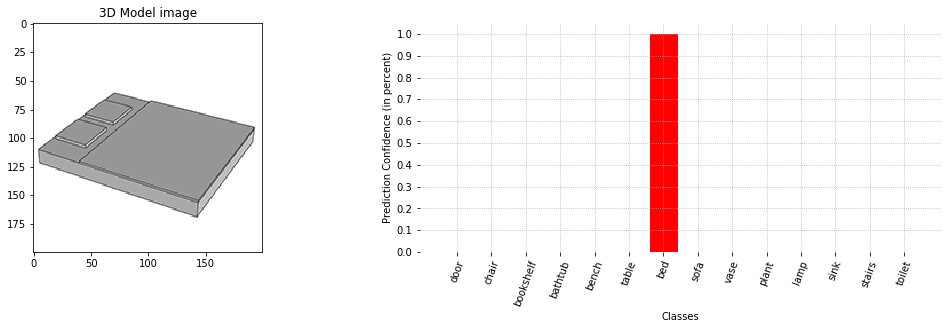

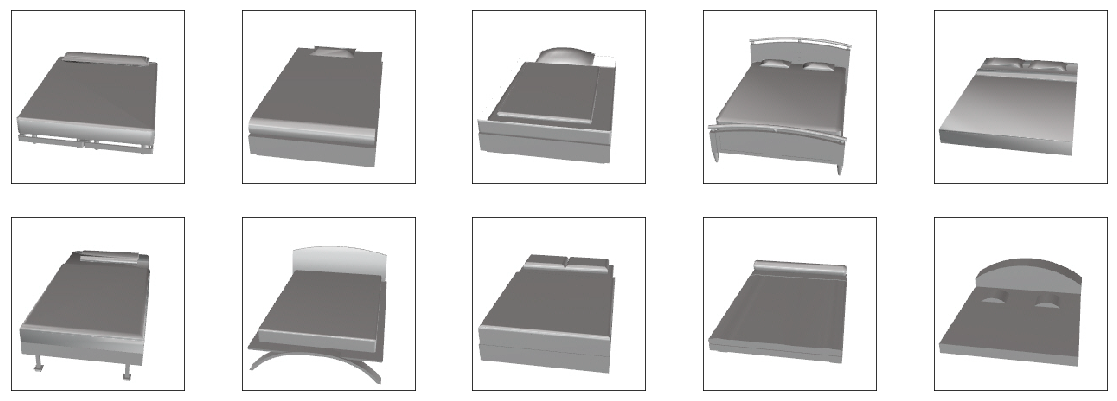

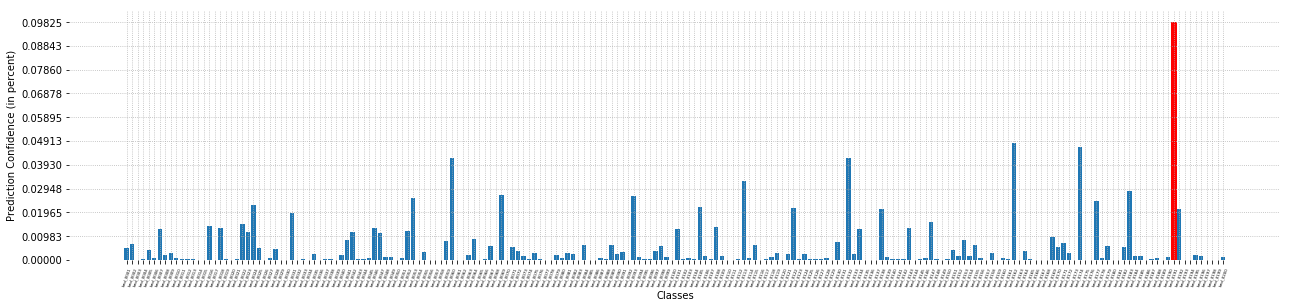

In [74]:
predict('bed')

--------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------
CLASS : chair
Prediction Confidence : 99.98162388801575%
-------------------------------------------------------------------
TOP TEN MATCHES:


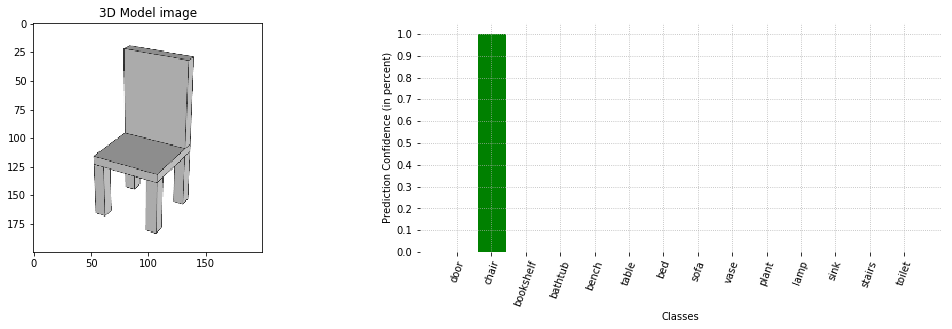

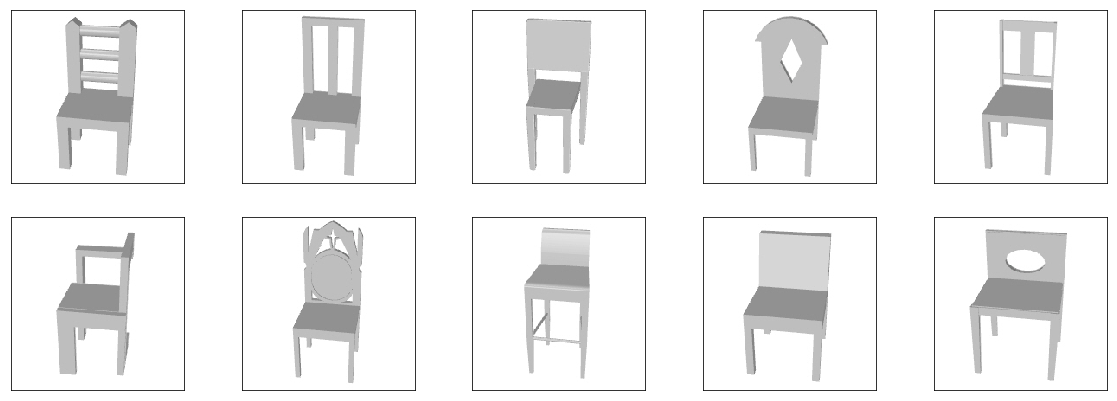

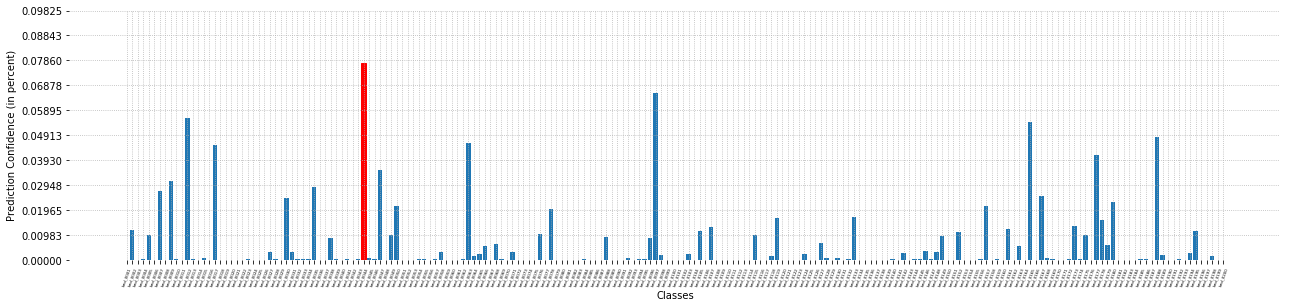

In [75]:
predict('chair')

--------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------
CLASS : bathtub
Prediction Confidence : 99.96175765991211%
-------------------------------------------------------------------
TOP TEN MATCHES:


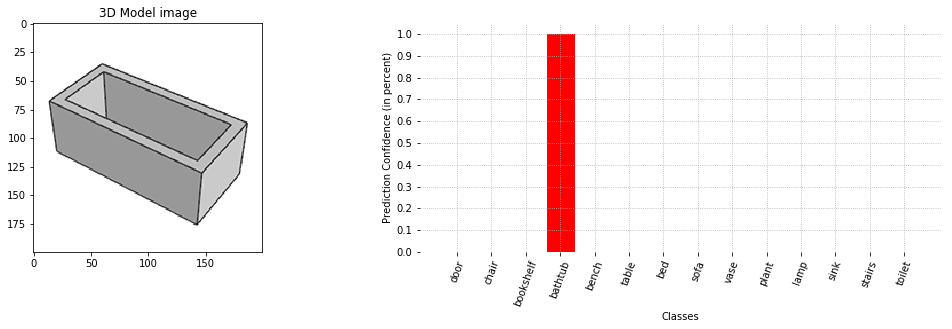

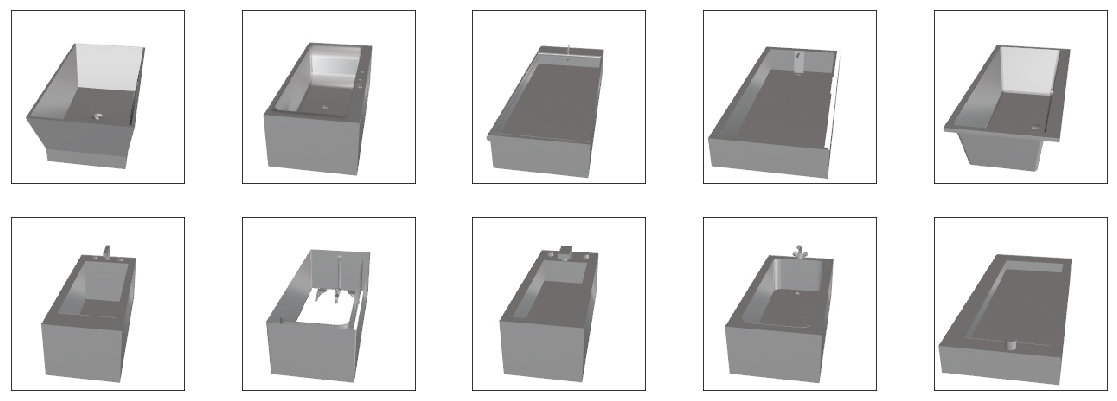

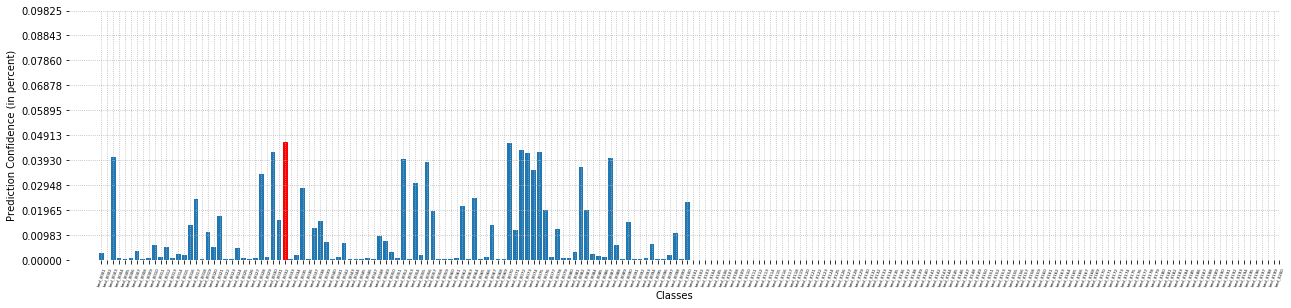

In [76]:
predict('bathtub')

-------------------------------------------------------------------
CLASS : bookshelf
Prediction Confidence : 99.88227486610413%
-------------------------------------------------------------------
TOP TEN MATCHES:


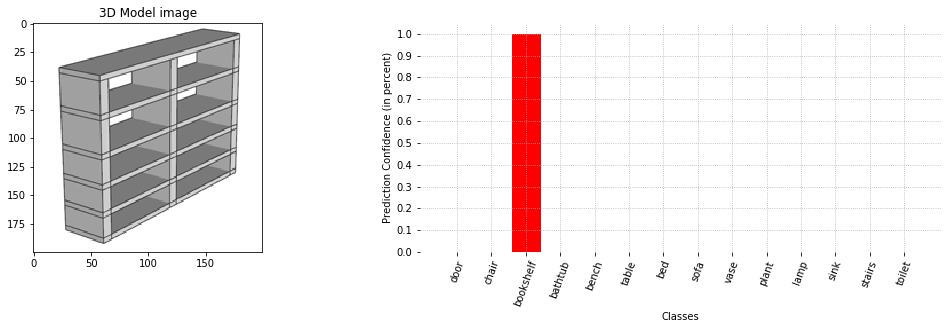

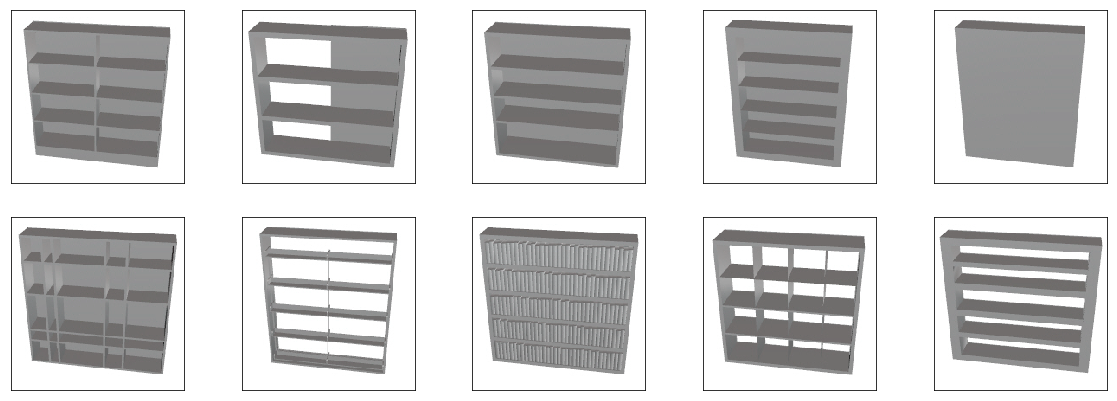

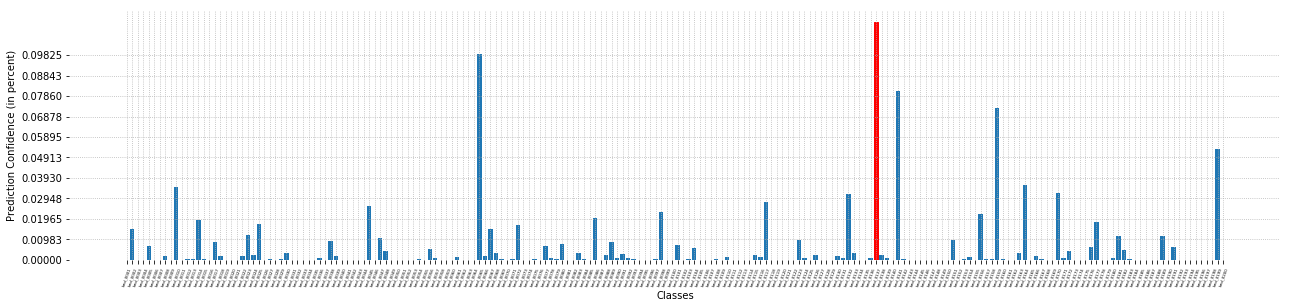

In [77]:
predict('bookshelf')

-------------------------------------------------------------------
CLASS : bench
Prediction Confidence : 99.9974250793457%
-------------------------------------------------------------------
TOP TEN MATCHES:


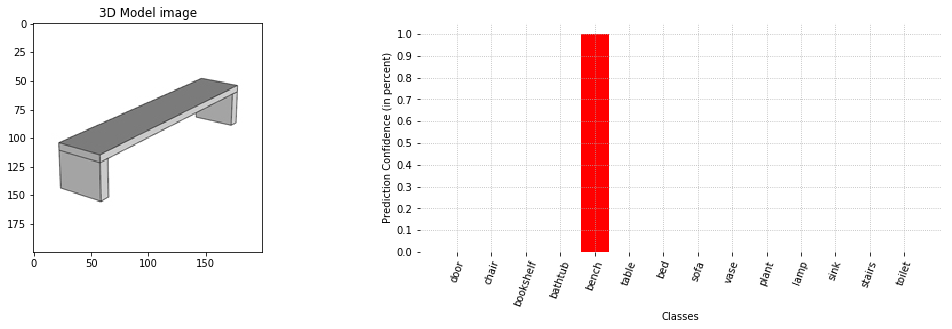

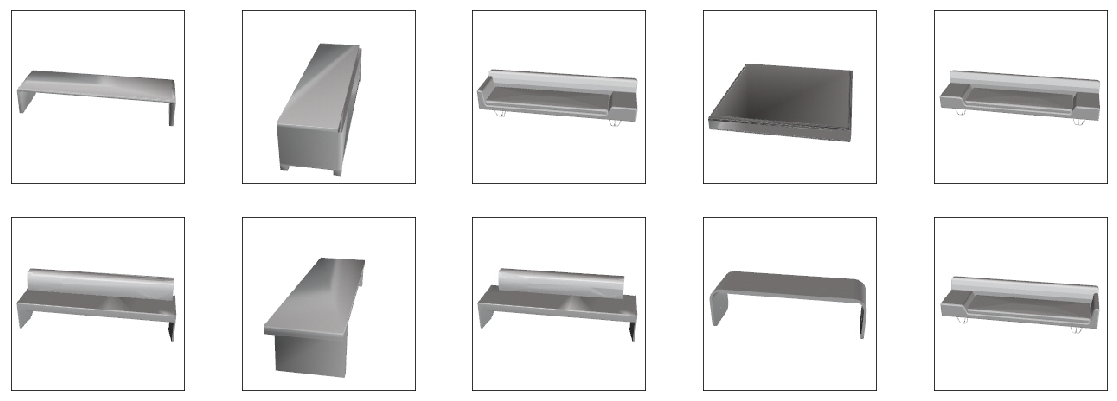

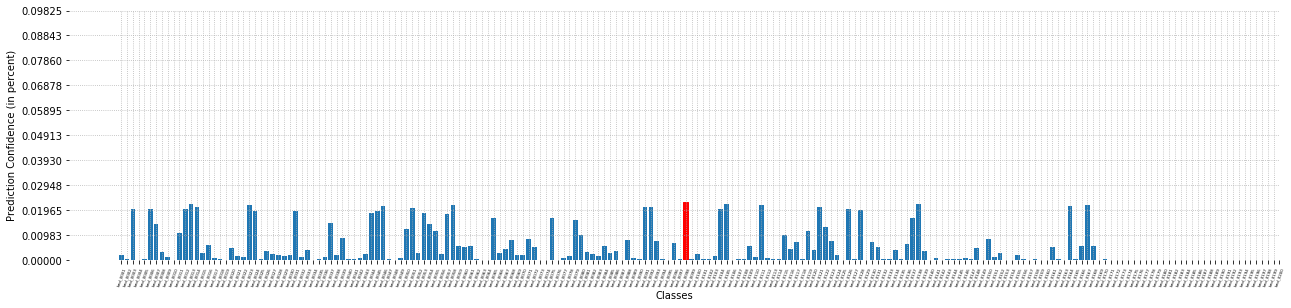

In [78]:
predict('bench')

-------------------------------------------------------------------
CLASS : door
Prediction Confidence : 100.0%
-------------------------------------------------------------------
TOP TEN MATCHES:


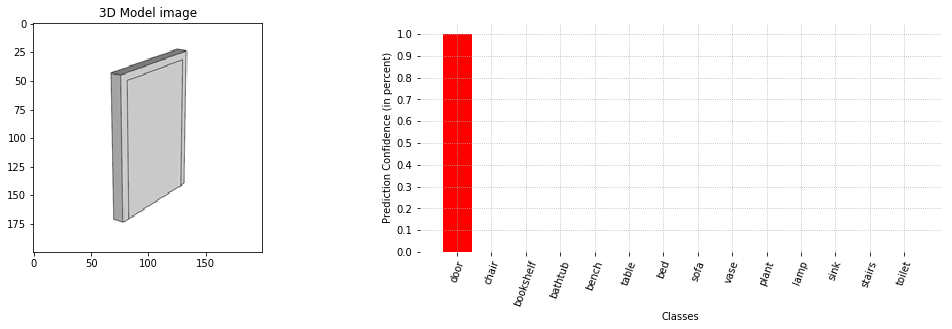

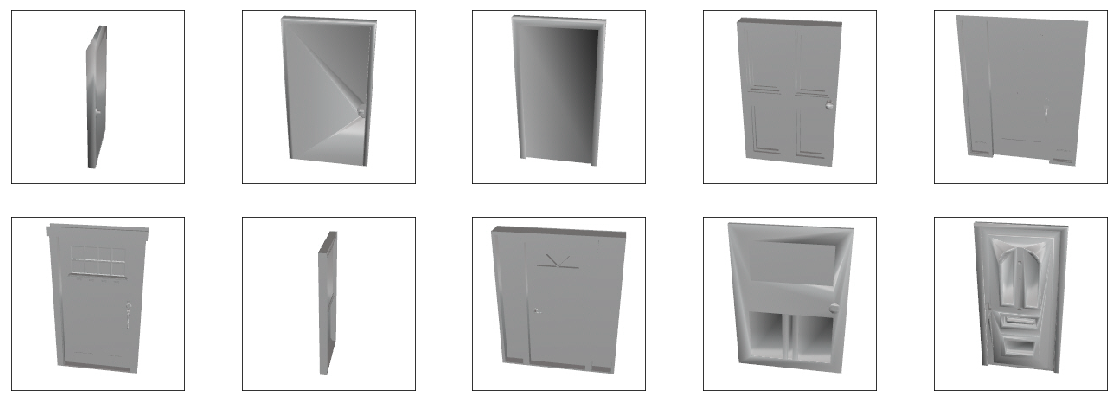

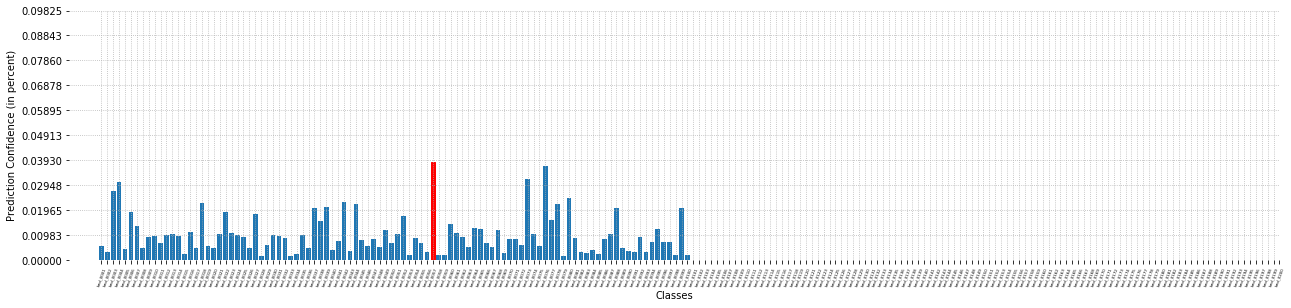

In [79]:
predict('door')

-------------------------------------------------------------------
CLASS : vase
Prediction Confidence : 100.0%
-------------------------------------------------------------------
TOP TEN MATCHES:


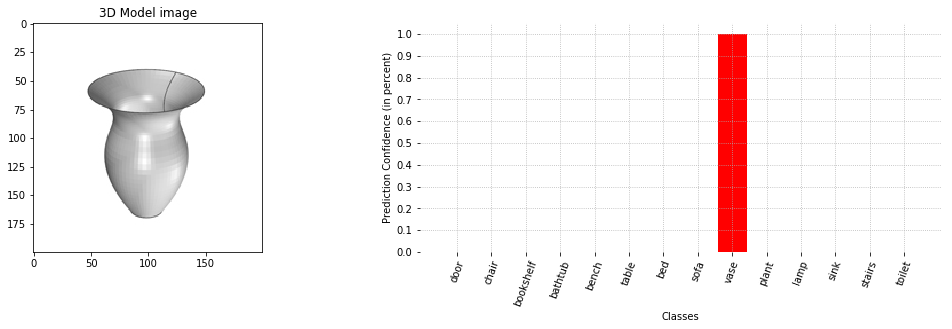

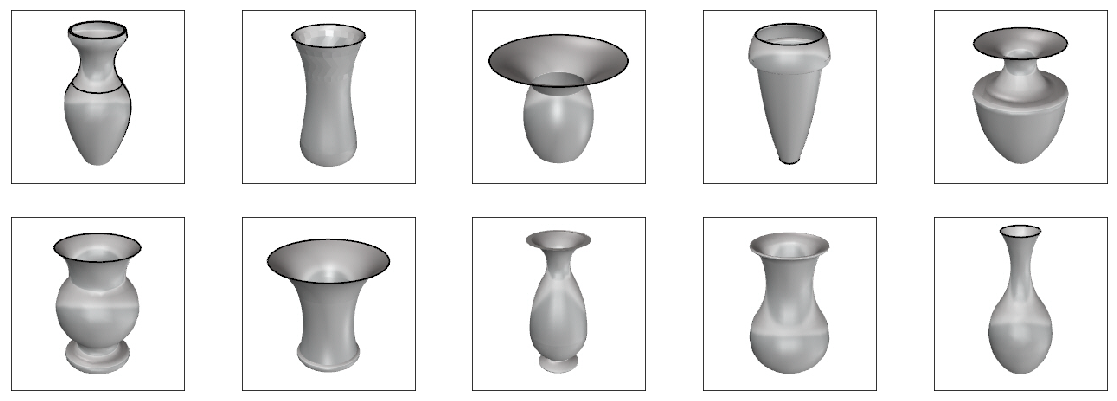

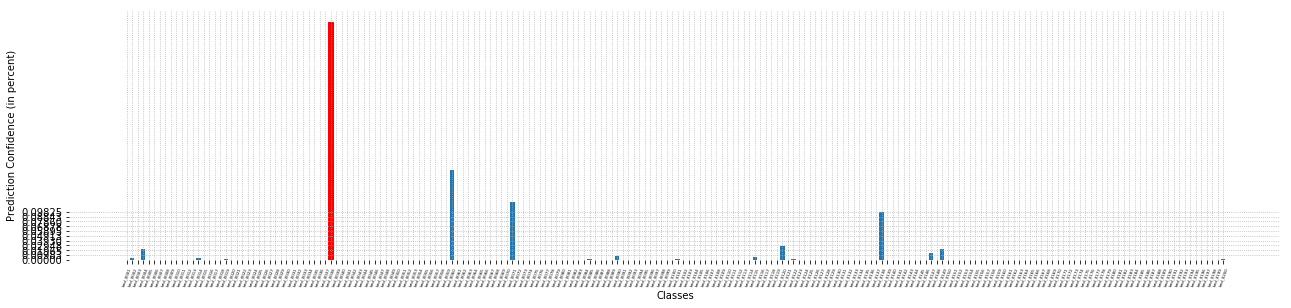

In [81]:
predict('vase')

-------------------------------------------------------------------
CLASS : chair
Prediction Confidence : 99.94008541107178%
-------------------------------------------------------------------
TOP TEN MATCHES:


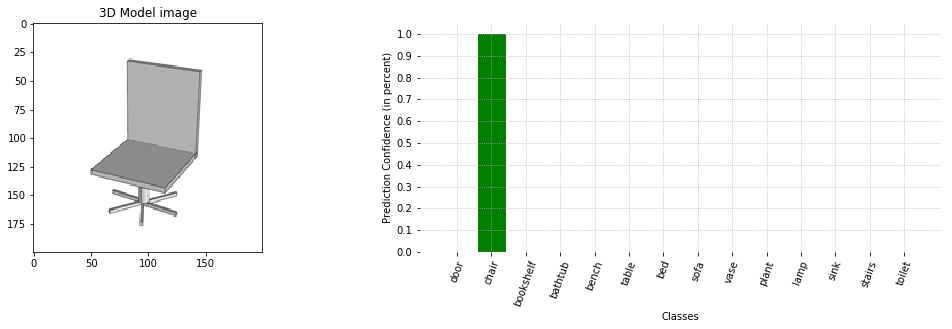

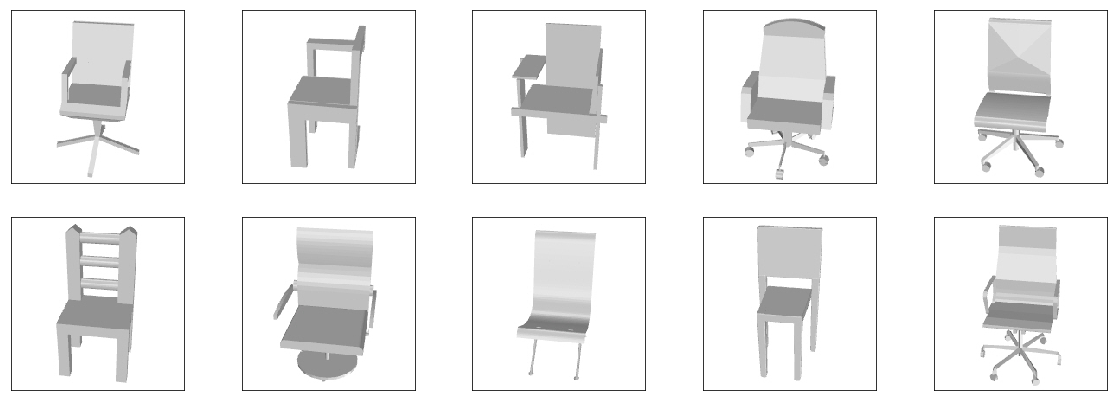

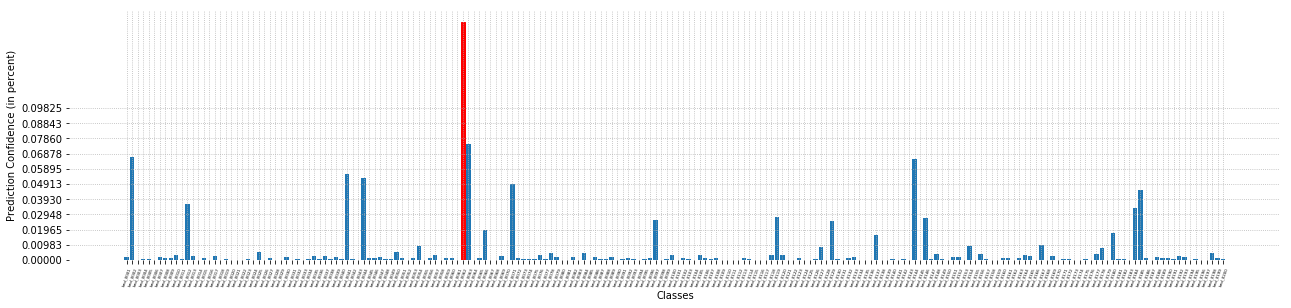

In [89]:
predict('chair_2')